# Strategic Asset Allocation using Python
### Efficient Frontier, Capital Allocation Line
- CAU Business School, Chung-Ang University
- 1 November, 2021
- Prof. Shiyong Yoo 

    - 본 코드는 2020년 중앙대 경영학부의 재무관리(유시용교수)의 자산배분 실습을 위한 코드로 개발되었습니다. 출처를 밝혀주셔도 좋고, 그냥 편하게 자유롭게 사용하실 수 있습니다. 

In [1]:
# pip install -q finance-datareader

In [2]:
# 먼저 필요한 module을 불러오자
import FinanceDataReader as fdr 
import seaborn as sns
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime 
import scipy.optimize as sco

# 전략적 자산배분 (Strategic Asset Allocation)
### 자산 유니버스 (Asset Universe)
### 자산군 (Asset Class)
  * 국내 및 해외
  * 주식, 채권, 대체투자
  
### 각 자산군에 대한 Benchmark Index 선정 

In [3]:
# 주가 데이터를 불러오자  
# (yahoo finance open API, 공식적으로 없어졌지만, 비공식적으로 서비스는 제공되고 있음)

start = datetime(2010,1,1)
end = datetime.today()

# 국내주식
kospi = pdr.DataReader('^KS11','yahoo',start,end) # KOSPI
# 국내 채권 수익률
kbr = fdr.DataReader('KR3YT=RR',start,end) # 3년만기 한국국채 수익률

# 해외주식
snp = pdr.DataReader('^GSPC','yahoo',start,end) #S&P500
# 해외채권 : Treasury Yield 10 Years (^TNX) NYBOT - NYBOT Real Time Price. Currency in USD
tr1 = pdr.DataReader('^tnx','yahoo',start,end)
tr2 = fdr.DataReader('US10YT=X',start,end) # 10년 만기 미국국채 수익률
# 해외 대체 : S&P-GSCI Commodity Index Future (GD=F) CME - CME Delayed Price. Currency in USD
com = pdr.DataReader('gd=f','yahoo',start,end)
# 해외대체2
gold = fdr.DataReader('ZG',start,end) # 금 선물 (ICE)

# FX 환율 (1995 ~ 현재)
wd = fdr.DataReader('USD/KRW', start,end) # 달러 원화


# 국내 대체 : Bitcoin KRW price (Bithumbs), 2016 ~ Now
bcw = fdr.DataReader('BTC/KRW', start,end)
bcu = pdr.DataReader('BTC-USD','yahoo',start,end)



In [4]:
kbr.head()

,Close,Open,High,Low,Change
Date,,,,,
2010-01-04,4.44,4.44,4.44,4.44,0.0023
2010-01-05,4.40,4.40,4.40,4.40,-0.0090
2010-01-06,4.44,4.44,4.44,4.44,0.0091
2010-01-07,4.40,4.40,4.40,4.40,-0.0090
2010-01-08,4.32,4.32,4.32,4.32,-0.0182


In [5]:
# 해외주식 
tsl = pdr.DataReader('tsla','yahoo',start,end)
apl = pdr.DataReader('aapl','yahoo',start,end)
ggl = pdr.DataReader('goog','yahoo',start,end)
nvd = pdr.DataReader('nvda','yahoo',start,end)


In [6]:
gold.head() 

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2010-01-04,1117.7,1097.1,1122.3,1097.1,180.0,0.0205
2010-01-05,1118.1,1122.0,1126.5,1115.0,50.0,0.0004
2010-01-06,1135.9,1120.7,1139.2,1120.7,360.0,0.0159
2010-01-07,1133.1,1132.1,1133.0,1129.2,60.0,-0.0025
2010-01-08,1138.2,1124.9,1136.9,1122.7,50.0,0.0045


In [7]:
kbr.head() 

,Close,Open,High,Low,Change
Date,,,,,
2010-01-04,4.44,4.44,4.44,4.44,0.0023
2010-01-05,4.40,4.40,4.40,4.40,-0.0090
2010-01-06,4.44,4.44,4.44,4.44,0.0091
2010-01-07,4.40,4.40,4.40,4.40,-0.0090
2010-01-08,4.32,4.32,4.32,4.32,-0.0182


In [8]:
tr2.head() 

,Close,Open,High,Low,Change
Date,,,,,
2010-01-04,3.823,3.823,3.823,3.823,-0.0036
2010-01-05,3.763,3.763,3.763,3.763,-0.0157
2010-01-06,3.829,3.829,3.829,3.829,0.0175
2010-01-07,3.827,3.827,3.827,3.827,-0.0005
2010-01-08,3.836,3.836,3.836,3.836,0.0024


In [9]:
bcu.head() 

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014


In [10]:
com.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,529.299988,524.900024,526.5,525.00,0.0,525.00
2010-01-04,538.900024,535.000000,535.0,539.00,0.0,539.00
2010-01-05,540.400024,535.799988,539.0,538.00,0.0,538.00
2010-01-06,548.000000,537.349976,538.0,547.50,0.0,547.50
2010-01-07,547.950012,542.000000,545.0,543.75,0.0,543.75


In [11]:
wd.head()

,Close,Open,High,Low,Change
Date,,,,,
2010-01-01,1166.08,1166.08,1166.08,1166.08,0.0000
2010-01-04,1150.00,1164.07,1164.07,1149.35,-0.0138
2010-01-05,1140.20,1151.00,1151.00,1136.30,-0.0085
2010-01-06,1129.20,1140.20,1144.70,1129.20,-0.0096
2010-01-07,1138.20,1129.20,1138.20,1127.80,0.0080


In [12]:
kospi.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1696.140015,1681.709961,1681.709961,1696.140015,296500.0,1696.140015
2010-01-05,1702.390015,1686.449951,1701.619995,1690.619995,408900.0,1690.619995
2010-01-06,1706.890015,1696.099976,1697.880005,1705.319946,426000.0,1705.319946
2010-01-07,1707.900024,1683.449951,1702.920044,1683.449951,462400.0,1683.449951
2010-01-08,1695.260010,1668.839966,1694.060059,1695.260010,380000.0,1695.260010


## 데이터 셋 모음

In [13]:
# com['Adj Close'] 관련 에러 발생 : dataframe을 reindex하는 과정에서 문제가 발생
print(com['Adj Close'].is_unique)
com = com.drop_duplicates(subset=['Adj Close'])
print(com['Adj Close'].is_unique)

False
True


In [14]:
saa = pd.DataFrame({
    'kp': kospi['Adj Close'],
    'snp': snp['Adj Close'],
    'ktr': kbr['Close'],
    'tr': tr2['Close'],
    'cmd': com['Adj Close'],
    'wd': wd['Close']
    }).dropna()

In [15]:
saa.head()

,kp,snp,ktr,tr,cmd,wd
Date,,,,,,
2010-01-04,1696.140015,1132.989990,4.44,3.823,539.000000,1150.00
2010-01-05,1690.619995,1136.520020,4.40,3.763,538.000000,1140.20
2010-01-06,1705.319946,1137.140015,4.44,3.829,547.500000,1129.20
2010-01-07,1683.449951,1141.689941,4.40,3.827,543.750000,1138.20
2010-01-08,1695.260010,1144.979980,4.32,3.836,542.450012,1128.25


In [16]:
eqt = pd.DataFrame({
    'kp': kospi['Adj Close'],
    'snp': snp['Adj Close'],
    'com': com['Adj Close'],
    'wd': wd['Close']
}).dropna()

In [17]:
eqt.head()

,kp,snp,com,wd
Date,,,,
2010-01-04,1696.140015,1132.989990,539.000000,1150.00
2010-01-05,1690.619995,1136.520020,538.000000,1140.20
2010-01-06,1705.319946,1137.140015,547.500000,1129.20
2010-01-07,1683.449951,1141.689941,543.750000,1138.20
2010-01-08,1695.260010,1144.979980,542.450012,1128.25


In [18]:
# fixed-income 
fi = pd.DataFrame({
    'ktr': kbr['Close'],
    'tr': tr2['Close']
}).dropna()

In [19]:
fi.head()

,ktr,tr
Date,,
2010-01-04,4.44,3.823
2010-01-05,4.40,3.763
2010-01-06,4.44,3.829
2010-01-07,4.40,3.827
2010-01-08,4.32,3.836


In [20]:
stk = pd.DataFrame({
    'apl': apl['Adj Close'],
    'ggl': ggl['Adj Close'],
    'tsl': tsl['Adj Close'],
    'nvd': nvd['Adj Close']
}).dropna()
stk.head()

,apl,ggl,tsl,nvd
Date,,,,
2010-06-29,7.855420,226.281845,4.778,2.407054
2010-06-30,7.713134,221.644226,4.766,2.345041
2010-07-01,7.619611,218.924423,4.392,2.384085
2010-07-02,7.572383,217.459900,3.840,2.354228
2010-07-06,7.624207,217.220810,3.222,2.328963


In [21]:
# 연속시간 수익률 (로그 차분)
rst= (np.log(stk) - np.log(stk.shift(1)) )*100
rst.columns=['apl','ggl','tsl' ,'nva']
rst.head()

,apl,ggl,tsl,nva
Date,,,,
2010-06-29,NaN,NaN,NaN,NaN
2010-06-30,-1.827913,-2.070781,-0.251469,-2.610087
2010-07-01,-1.219934,-1.234694,-8.172259,1.651288
2010-07-02,-0.621742,-0.671211,-13.431241,-1.260281
2010-07-06,0.682039,-0.110007,-17.547010,-1.078985


In [22]:
# 연속시간 수익률 (로그 차분)
rtn= (np.log(eqt) - np.log(eqt.shift(1)) )*100
rtn.columns=['r_kp','r_sp','r_com' ,'r_wd']
rtn.head()

,r_kp,r_sp,r_com,r_wd
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,-0.325977,0.311083,-0.185701,-0.855826
2010-01-06,0.865742,0.054537,1.750390,-0.969427
2010-01-07,-1.290751,0.399322,-0.687288,0.793865
2010-01-08,0.699090,0.287758,-0.239364,-0.878031


In [23]:
# No FX hedge 
rtn['r_sp_nh'] =rtn['r_sp']+rtn['r_wd']
rtn['com_nh'] =rtn['r_com']+rtn['r_wd']

# Full FX hedge 
rtn['r_sp_fh'] =rtn['r_sp']


In [24]:
rtn.head()

,r_kp,r_sp,r_com,r_wd,r_sp_nh,com_nh,r_sp_fh
Date,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,-0.325977,0.311083,-0.185701,-0.855826,-0.544742,-1.041527,0.311083
2010-01-06,0.865742,0.054537,1.750390,-0.969427,-0.914890,0.780963,0.054537
2010-01-07,-1.290751,0.399322,-0.687288,0.793865,1.193187,0.106577,0.399322
2010-01-08,0.699090,0.287758,-0.239364,-0.878031,-0.590272,-1.117395,0.287758


## 이자율 일별 수익률로 전환

In [25]:
fid = ( (1+fi/100)**(1/360) -1 )*100

In [26]:
fid.head()

,ktr,tr
Date,,
2010-01-04,0.012068,0.010422
2010-01-05,0.011962,0.010261
2010-01-06,0.012068,0.010438
2010-01-07,0.011962,0.010433
2010-01-08,0.011749,0.010457


## 월별 수익률 데이터로 전환

In [27]:
# 자산배분의 데이터 주기가 월별이랍니다. 
# 그래서 일별 주가수익률의 자료를 월별 주가수익률 자료로 환산시켜줍니다. 

rs= rtn.resample('M').sum()
rb =fid.resample('M').sum() 

ri = rst.resample('M').sum()
# 변수 이름 단순화 
rs.columns=['kp', 'sp', 'com', 'wd', 'sp_nh', 'sp_fh', 'com_nh'] 


# date format: yyyy-mm-dd ==> yyyy-mm
rs = rs.to_period('M')
rb = rb.to_period('M')
ri = ri.to_period('M')


In [28]:
rs.head()

,kp,sp,com,wd,sp_nh,sp_fh,com_nh
Date,,,,,,,
2010-01,-5.683383,-5.359121,-10.268425,0.770934,-4.588187,-9.497492,-5.359121
2010-02,-0.491091,2.811474,6.342643,0.094873,2.906347,6.437516,2.811474
2010-03,5.929499,6.036840,1.103393,-2.134692,3.902148,-1.031299,6.036840
2010-04,2.887595,1.141579,4.523970,-2.406533,-1.264954,2.117437,1.141579
2010-05,-7.064055,-8.553157,-11.334693,7.513844,-1.039314,-3.820849,-8.553157


In [29]:
rb.head()

,ktr,tr
Date,,
2010-01,0.221914,0.192317
2010-02,0.216483,0.190721
2010-03,0.236031,0.223508
2010-04,0.227126,0.229280
2010-05,0.191519,0.176703


In [30]:
# 가격 데이터와 수익률 데이트를 머지해주어요. 

aa = pd.merge(rs,rb, left_index=True, right_index=True, how='inner')

# No FX hedge 해외채권
aa['tr_nh'] =aa['tr'] +aa['wd']
aa.head()

,kp,sp,com,wd,sp_nh,sp_fh,com_nh,ktr,tr,tr_nh
Date,,,,,,,,,,
2010-01,-5.683383,-5.359121,-10.268425,0.770934,-4.588187,-9.497492,-5.359121,0.221914,0.192317,0.963251
2010-02,-0.491091,2.811474,6.342643,0.094873,2.906347,6.437516,2.811474,0.216483,0.190721,0.285593
2010-03,5.929499,6.036840,1.103393,-2.134692,3.902148,-1.031299,6.036840,0.236031,0.223508,-1.911184
2010-04,2.887595,1.141579,4.523970,-2.406533,-1.264954,2.117437,1.141579,0.227126,0.229280,-2.177253
2010-05,-7.064055,-8.553157,-11.334693,7.513844,-1.039314,-3.820849,-8.553157,0.191519,0.176703,7.690547


In [31]:
aanh=aa[['kp', 'ktr', 'sp_nh','tr_nh','com_nh' ]]
aanh.head()

,kp,ktr,sp_nh,tr_nh,com_nh
Date,,,,,
2010-01,-5.683383,0.221914,-4.588187,0.963251,-5.359121
2010-02,-0.491091,0.216483,2.906347,0.285593,2.811474
2010-03,5.929499,0.236031,3.902148,-1.911184,6.036840
2010-04,2.887595,0.227126,-1.264954,-2.177253,1.141579
2010-05,-7.064055,0.191519,-1.039314,7.690547,-8.553157


In [32]:
aafh=aa[['kp', 'ktr', 'sp','tr','com' ]]
aafh.head()

,kp,ktr,sp,tr,com
Date,,,,,
2010-01,-5.683383,0.221914,-5.359121,0.192317,-10.268425
2010-02,-0.491091,0.216483,2.811474,0.190721,6.342643
2010-03,5.929499,0.236031,6.036840,0.223508,1.103393
2010-04,2.887595,0.227126,1.141579,0.229280,4.523970
2010-05,-7.064055,0.191519,-8.553157,0.176703,-11.334693


In [33]:
data=aanh

### 월별 누적 수익률

In [34]:
cr_nh =(1+data/100).cumprod()
cr_nh.head()

,kp,ktr,sp_nh,tr_nh,com_nh
Date,,,,,
2010-01,0.943166,1.002219,0.954118,1.009633,0.946409
2010-02,0.938534,1.004389,0.981848,1.012516,0.973017
2010-03,0.994185,1.006759,1.020161,0.993165,1.031756
2010-04,1.022893,1.009046,1.007257,0.971541,1.043535
2010-05,0.950635,1.010979,0.996788,1.046258,0.954279


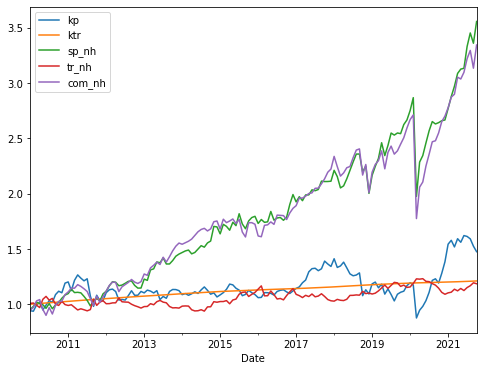

In [35]:
cr_nh.plot(figsize=(8,6))
plt.legend(loc=2);

<AxesSubplot:xlabel='Date'>

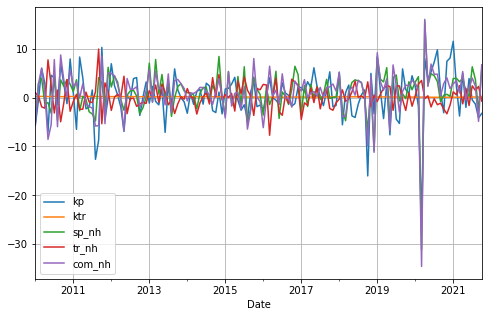

In [36]:
data.plot(figsize=(8, 5), grid=True)

### 개별 주식 (해외)

In [37]:
cri =(1+ri/100).cumprod()
cri.head()

,apl,ggl,tsl,nva
Date,,,,
2010-06,0.981721,0.979292,0.997485,0.973899
2010-07,1.003796,1.063392,0.819716,0.871394
2010-08,0.947006,0.984118,0.800584,0.884569
2010-09,1.093433,1.137257,0.837921,1.083281
2010-10,1.157890,1.313082,0.894663,1.114365


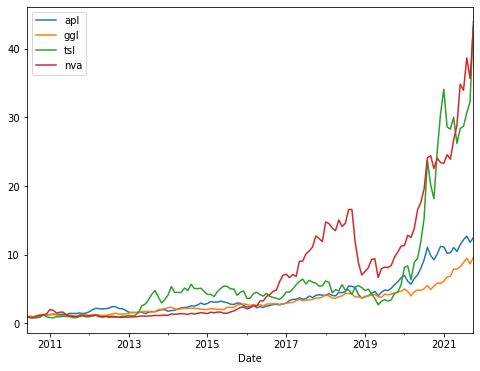

In [38]:
cri.plot(figsize=(8,6))
plt.legend(loc=2);

## 국내채권 (ktr), 해외 대체(com_nh) 제외

In [39]:
data=aa[['kp', 'sp_nh','tr_nh' ]]
data.head()

,kp,sp_nh,tr_nh
Date,,,
2010-01,-5.683383,-4.588187,0.963251
2010-02,-0.491091,2.906347,0.285593
2010-03,5.929499,3.902148,-1.911184
2010-04,2.887595,-1.264954,-2.177253
2010-05,-7.064055,-1.039314,7.690547


In [40]:
cr_nh =(1+data/100).cumprod()
cr_nh.head()

,kp,sp_nh,tr_nh
Date,,,
2010-01,0.943166,0.954118,1.009633
2010-02,0.938534,0.981848,1.012516
2010-03,0.994185,1.020161,0.993165
2010-04,1.022893,1.007257,0.971541
2010-05,0.950635,0.996788,1.046258


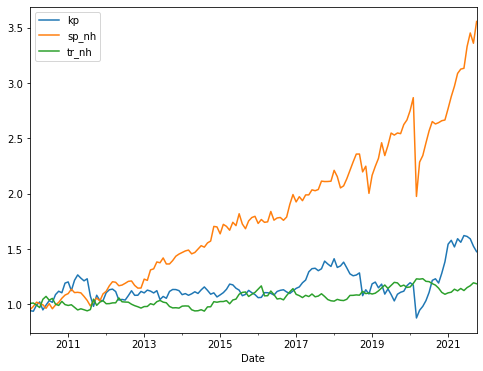

In [41]:
cr_nh.plot(figsize=(8,6))
plt.legend(loc=2);

In [42]:
data.mean()

kp       0.394673
sp_nh    1.002408
tr_nh    0.149758
dtype: float64

In [43]:
data.cov()

,kp,sp_nh,tr_nh
kp,23.042078,10.841273,-6.444487
sp_nh,10.841273,19.337136,0.457435
tr_nh,-6.444487,0.457435,5.882917


In [44]:
data.corr()

,kp,sp_nh,tr_nh
kp,1.000000,0.513598,-0.553517
sp_nh,0.513598,1.000000,0.042888
tr_nh,-0.553517,0.042888,1.000000


### 포트폴리오 최적화 (portfolio optimization) 기초

In [45]:
rmon = data/100 # 월별 수익률, % 단위 제거 
noa=np.size(rmon,1)
noa

3

In [46]:
rmon.head()

,kp,sp_nh,tr_nh
Date,,,
2010-01,-0.056834,-0.045882,0.009633
2010-02,-0.004911,0.029063,0.002856
2010-03,0.059295,0.039021,-0.019112
2010-04,0.028876,-0.012650,-0.021773
2010-05,-0.070641,-0.010393,0.076905


In [47]:
df=rmon
stats = df.describe()
stats.loc['var'] = df.var().tolist()
stats.loc['skew'] = df.skew().tolist()
stats.loc['kurt'] = df.kurtosis().tolist()
print(stats)

               kp       sp_nh       tr_nh
count  142.000000  142.000000  142.000000
mean     0.003947    0.010024    0.001498
std      0.048002    0.043974    0.024255
min     -0.253154   -0.311138   -0.077119
25%     -0.018382   -0.008560   -0.013048
50%      0.008829    0.011847    0.000982
75%      0.029922    0.036190    0.017702
max      0.114954    0.156999    0.099083
var      0.002304    0.001934    0.000588
skew    -1.288145   -2.658845    0.336060
kurt     5.819094   19.962178    1.864510


<AxesSubplot:>

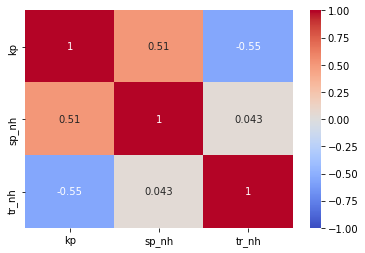

In [48]:
sns.heatmap(rmon.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

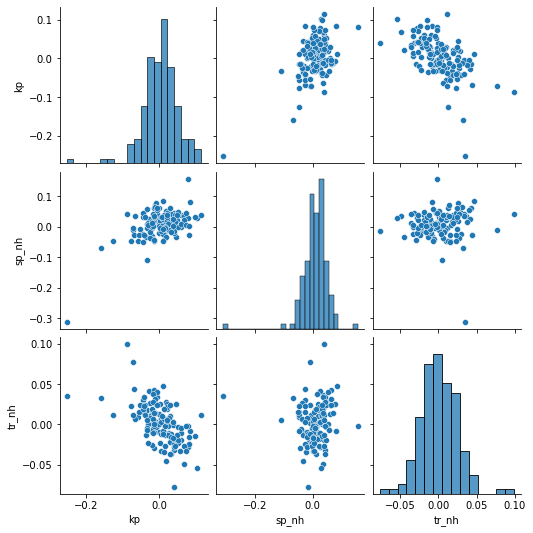

In [49]:
sns.pairplot(rmon)

In [50]:
# 공매도 금지 (w >=0)
weights = np.random.random(noa) # uniform dist [0,1]
weights /= np.sum(weights)
weights

array([0.5501206 , 0.276486  , 0.17339339])

In [51]:
# 공매도 허용 (w< 0 가능) : 정규분포 ==> 너무 과도한 배분 
weight_short = np.random.randn(noa) # 표준정규분포로부터 난수 생성
weight_short /= np.sum(weight_short)
weight_short

array([-0.44326144,  0.7217523 ,  0.72150914])

In [52]:
# 공매도 허용 (w< 0 가능) : [-1, 1] uniform ==> 그런대로 OK!
weight_short = np.random.uniform(low=-1, high=1, size=noa) # [-1, 1] uniform 난수 생성
weight_short /= np.sum(weight_short)
weight_short

array([ 2.32670608, -3.5958371 ,  2.26913102])

In [53]:
# 기대 수익률
np.sum(rmon.mean() * weights) * 12

0.06242840008428813

In [54]:
# 기대 분산 (expected portfolio variance)
np.dot(weights.T, np.dot(rmon.cov() * 12, weights))

0.012888863886713706

In [55]:
# 기대 변동성 (expected portfolio standard deviation/volatility)
np.sqrt(np.dot(weights.T, np.dot(rmon.cov() * 12, weights)))

0.11352913232608494

In [56]:
def gen_port(returns, iterations=1000):
    pret = []
    pstd = []
    
    for i in range(iterations):
        weights = np.random.random(noa) # 공매도 금지
#        weights= np.random.uniform(low=-1, high=1, size=noa) -1 #공매도 허용 [-1, 1] 난수
        weights/=np.sum(weights)
        pret.append(np.sum(returns.mean()*weights)*12)
        pstd.append(np.sqrt(np.dot(weights.T,np.dot(returns.cov()*12,weights))))
        
    pret = np.array(pret)
    pstd = np.array(pstd)
    return pret, pstd 

In [57]:
def gen_port_short(returns, iterations=1000):
    pret = []
    pstd = []
    
    for i in range(iterations):
#        weights = np.random.random(noa) # 공매도 금지
        weights_short= np.random.uniform(low=-0.2, high=1, size=noa)  #공매도 허용 [-0.2, 1] 난수
        weights_short/=np.sum(weights_short)
        pret.append(np.sum(returns.mean()*weights_short)*12)
        pstd.append(np.sqrt(np.dot(weights_short.T,np.dot(returns.cov()*12,weights_short))))
        
    pret = np.array(pret)
    pstd = np.array(pstd)
    return pret, pstd 

In [58]:
def plot_port(returns, std):
    plt.figure(figsize=(10,6))
    plt.scatter(std,returns, c=returns/std,marker='o', cmap=mpl.cm.jet) # c= Sharpe Ratio <== r_f =0 가정
    plt.grid(True)
    plt.xlabel('Expected STD')
    plt.ylabel("Expected Return")
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

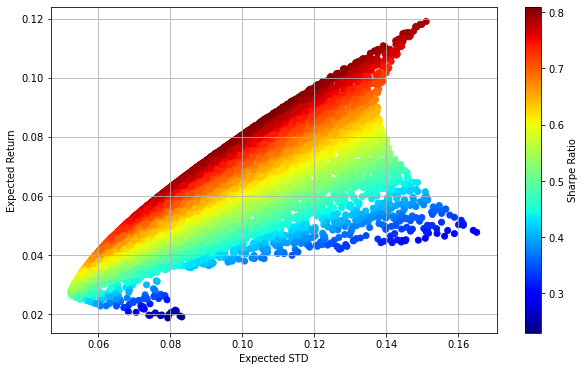

In [59]:
pret,pstd = gen_port(rmon, 10000)
plot_port(pret, pstd)

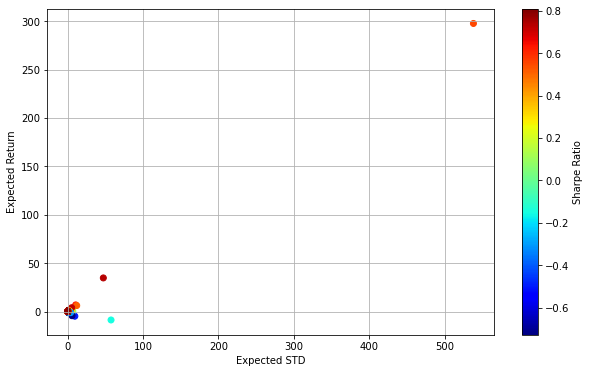

In [60]:
pret_short,pstd_short = gen_port_short(rmon, 10000)
plot_port(pret_short, pstd_short)

### 포트폴리오 최적화

In [61]:
def stat_port(weights, returns):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pstd : float
        expected portfolio volatility
    pret / pstd : float
        Sharpe ratio for r_f=0 가정 
    '''
    weights = np.array(weights)
    pret = np.sum(returns.mean() * weights) * 12
    pstd = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 12, weights)))
    return np.array([pret, pstd, pret / pstd])

In [62]:
def min_func_sharpe(weights, returns):
    return -stat_port(weights, returns)[2]

In [63]:
test1= stat_port(weights, rmon)
test1

array([0.0624284 , 0.11352913, 0.54988882])

In [64]:
test2 = stat_port(weights, rmon)[2]
test2

0.5498888153657131

In [65]:
test3= min_func_sharpe(weights, rmon)
test3

-0.5498888153657131

In [66]:
def optimize_portfolio(weights, returns):
    constraints = ({'type':'eq','fun': lambda x: np.sum(x)-1}) #the sum of weights is 1
    bounds = tuple((0,1) for x in range(noa)) 
    optimum=sco.minimize(fun=min_func_sharpe,x0=weights,args=returns,method='SLSQP',bounds=bounds,constraints=constraints) 
    return optimum 
    # min_func_sharpe (-Sharpe ratio) 최소화 ==> Sharpe ratio 최대화

In [67]:
opts=optimize_portfolio(weights,rmon)
opts

     fun: -0.8099549434400314
     jac: array([ 0.02500558, -0.00010157,  0.00024245])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.        , 0.70473597, 0.29526403])

In [68]:
#"Optimal weights:" 
opts['x'].round(3)

array([0.   , 0.705, 0.295])

In [69]:
# 최적: 평균, vol, Sharpe ratio 
stat_port(opts['x'], rmon).round(3) 

array([0.09 , 0.111, 0.81 ])

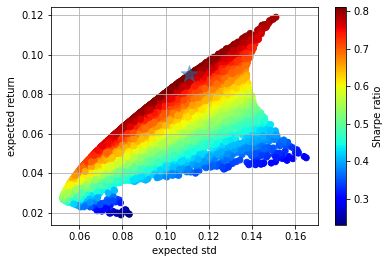

In [70]:
plt.scatter(pstd, pret, c=pret/pstd, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected std')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_opts = stat_port(opts['x'], rmon).round(3) 
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=300, alpha=0.5)
plt.show()

### 최소분산 포트폴리오

In [71]:
# 목적함수: 포트폴리오 분산
def min_func_variance(weights, returns):
    return stat_port(weights, returns)[1] ** 2 

In [72]:
test1=stat_port(weights, rmon) 
test1

array([0.0624284 , 0.11352913, 0.54988882])

In [73]:
test2=stat_port(weights, rmon)[1] 
test2

0.11352913232608494

In [74]:
test3=min_func_variance(weights, rmon)
test3

0.012888863886713705

In [75]:
def minimize_variance(weights, returns):
    constraints = ({'type':'eq','fun': lambda x: np.sum(x)-1}) #the sum of weights is 1
    bounds = tuple((0,1) for x in range(noa)) 
    optimum=sco.minimize(fun=min_func_variance,x0=weights,args=returns,method='SLSQP',bounds=bounds,constraints=constraints) 
    return optimum 
    # min_func_variance (==> 분산) 최소화 ==> 분산 최소화 

In [76]:
optv =minimize_variance(weights, rmon) 
optv

     fun: 0.0026983300825732044
     jac: array([0.00538795, 0.00844193, 0.0054003 ])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([2.94692331e-01, 5.63785130e-18, 7.05307669e-01])

In [77]:
#"Optimal weights:" 
optv['x'].round(3)

array([0.295, 0.   , 0.705])

In [78]:
# 최적: 평균, vol, Sharpe ratio 
stat_port(optv['x'], rmon).round(3)

array([0.027, 0.052, 0.513])

In [79]:
test0=stat_port(optv['x'], rmon)
test0

array([0.02663187, 0.05194545, 0.51268913])

In [80]:
test1=stat_port(optv['x'], rmon)[1]**2
test1

0.0026983300825732044

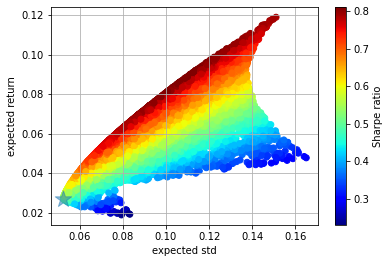

In [81]:
plt.scatter(pstd, pret, c=pret/pstd, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected std')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_optv = stat_port(optv['x'], rmon).round(3) 
plt.scatter(pt_optv[1], pt_optv[0], marker="*", s=300, alpha=0.5)
plt.show()



### Efficient Frontier

In [82]:
cons = ({'type': 'eq', 'fun': lambda x:  stat_port(x,rmon)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [83]:
# 포트폴리오의 변동성
def min_func_port(weights):
    return stat_port(weights, rmon)[1]

In [84]:
test0=stat_port(weights, rmon)
test0

array([0.0624284 , 0.11352913, 0.54988882])

In [85]:
test = min_func_port(weights)
test

0.11352913232608494

In [86]:
%%time
trets = np.linspace(min(pret), max(pret), 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  stat_port(x, rmon)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

Wall time: 2.53 s


In [87]:
tvols

array([0.07923485, 0.0682331 , 0.05932434, 0.05356328, 0.05200672,
       0.05277181, 0.05367187, 0.05469985, 0.05584868, 0.05711107,
       0.05847967, 0.05994721, 0.0615066 , 0.06315104, 0.06487406,
       0.06666957, 0.06853188, 0.07045568, 0.07243607, 0.07446855,
       0.07654895, 0.07867349, 0.08083869, 0.08304136, 0.0852786 ,
       0.08754777, 0.08984643, 0.09217238, 0.0945236 , 0.09689827,
       0.09929469, 0.10171133, 0.10414674, 0.10659967, 0.10906935,
       0.11157635, 0.11413041, 0.11672843, 0.11936756, 0.12204511,
       0.12475862, 0.1275058 , 0.1302845 , 0.13309276, 0.13592875,
       0.13879076, 0.14167723, 0.14458667, 0.14751774, 0.15046917])

In [88]:
def efficient_variance(weights, returns):

    trets = np.linspace(min(pret), max(pret), 50)
    tvols = []
    for tret in trets:
      cons = ({'type': 'eq', 'fun': lambda x:  stat_port(x, returns)[0] - tret},
              {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
      res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
#      tvols.append(res['fun'])
      tvols = np.array(tvols)
    return tvols

In [89]:
efficient_variance(weights, rmon)

array([], dtype=float64)

In [90]:
tvols

array([0.07923485, 0.0682331 , 0.05932434, 0.05356328, 0.05200672,
       0.05277181, 0.05367187, 0.05469985, 0.05584868, 0.05711107,
       0.05847967, 0.05994721, 0.0615066 , 0.06315104, 0.06487406,
       0.06666957, 0.06853188, 0.07045568, 0.07243607, 0.07446855,
       0.07654895, 0.07867349, 0.08083869, 0.08304136, 0.0852786 ,
       0.08754777, 0.08984643, 0.09217238, 0.0945236 , 0.09689827,
       0.09929469, 0.10171133, 0.10414674, 0.10659967, 0.10906935,
       0.11157635, 0.11413041, 0.11672843, 0.11936756, 0.12204511,
       0.12475862, 0.1275058 , 0.1302845 , 0.13309276, 0.13592875,
       0.13879076, 0.14167723, 0.14458667, 0.14751774, 0.15046917])

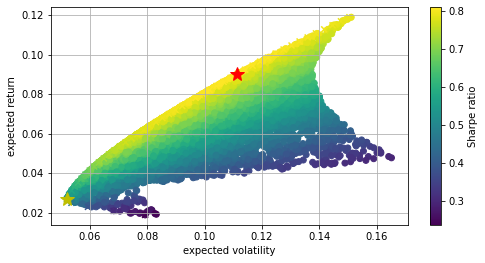

In [91]:
plt.figure(figsize=(8, 4))
plt.scatter(pstd, pret,
            c=pret / pstd, marker='o')
            # random portfolio composition
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x')
            # efficient frontier
plt.plot(stat_port(opts['x'],rmon)[1], stat_port(opts['x'],rmon)[0],
         'r*', markersize=15.0)
            # portfolio with highest Sharpe ratio
plt.plot(stat_port(optv['x'],rmon)[1], stat_port(optv['x'],rmon)[0],
         'y*', markersize=15.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

## Utility Function

$$U = E(r_c)-0.5A\sigma_c^2$$

## Capital Allocation Line

$$E(r_c) = r_f + \frac{E(r_p)-r_f}{\sigma_p}\sigma_c$$

$p$ is the risky portfolio, $f$ is riskless portfolio, and $c$ is a combination of portfolios $p$ and $f$.

In [92]:
cal_x = []
cal_y = []
utility = []
a = 10
rf = 0.0

for er in np.linspace(rf, max(pret), 500):
    sd = (er - rf)/((stat_port(opts['x'],rmon)[0]-rf)/stat_port(opts['x'],rmon)[1])
    u = er - .5*a*(sd**2)
    cal_x.append(sd)
    cal_y.append(er)
    utility.append(u)

In [93]:
dt2 = ({'utility':utility, 'cal_y':cal_y, 'cal_x':cal_x})
cal = pd.DataFrame(dt2)
#cal = np.array([utility, cal_x, cal_y])
cal.head()


,utility,cal_y,cal_x
0,0.000000,0.000000,0.000000
1,0.000238,0.000238,0.000294
2,0.000475,0.000477,0.000589
3,0.000712,0.000715,0.000883
4,0.000947,0.000954,0.001178


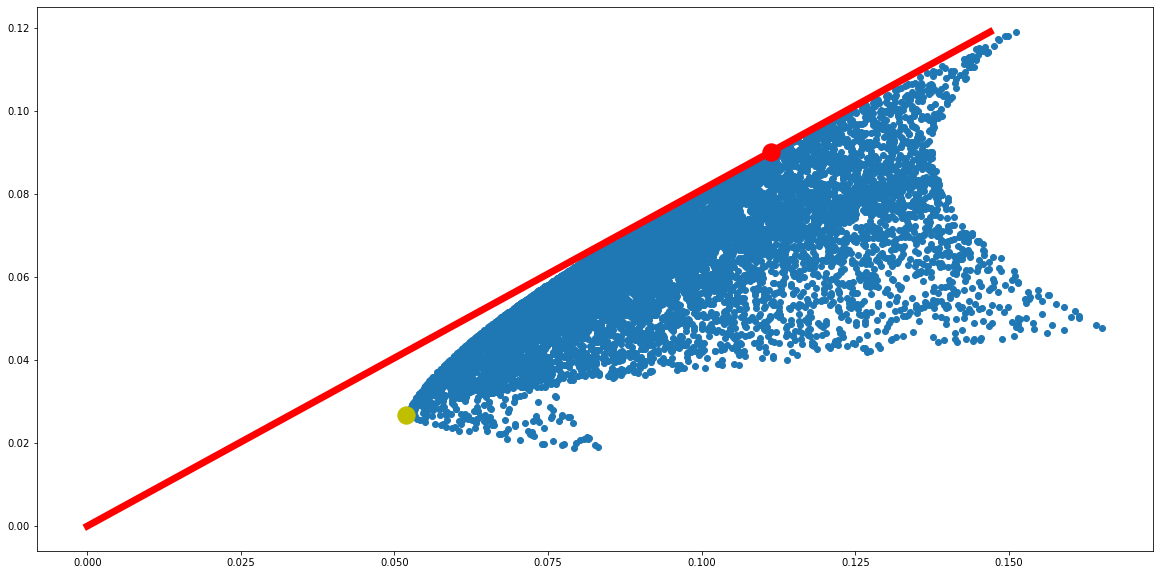

In [94]:
plt.subplots(figsize=(20,10))
#plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(pstd, pret)

#plt.scatter(min_var_port[1], min_var_port[0], color='y')
plt.scatter(stat_port(optv['x'],rmon)[1], stat_port(optv['x'],rmon)[0], color='y', s=300)


#plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g')
plt.scatter(stat_port(opts['x'],rmon)[1], stat_port(opts['x'],rmon)[0], color='r', s=300)

plt.plot(cal_x, cal_y, color='r',linewidth=7.0)

#Investor's Optimal Portfolio

In [95]:
cal['utility'].idxmax()

275

In [96]:
cal['utility'].head()

0    0.000000
1    0.000238
2    0.000475
3    0.000712
4    0.000947
Name: utility, dtype: float64

In [97]:
investors_port = cal.iloc[cal['utility'].idxmax()]
investors_port

utility    0.032801
cal_y      0.065584
cal_x      0.080973
Name: 275, dtype: float64

### Complete portfolio (위험자산+무위험자산) 에서 위험자산 구성 비중
- $ E(r_c) = (1 - w_{risky}) r_f  +  w_{risky} E(r_p)$
- $ w_{risky}=\frac{E(r_c) - r_f}{E(r_p)-r_f}$

In [98]:
# 1단계 CAL 상의 무위험 자산 및 위험자산 투자 비중 (1)

w_risky = (investors_port['cal_y']- rf )/(stat_port(opts['x'],rmon)[0]-rf) 
w_rf = 1-w_risky
print('위험자산 투자 비중   : %3.2f' %w_risky)
print('무위험자산 투자 비중 : %3.2f' %w_rf)

위험자산 투자 비중   : 0.73
무위험자산 투자 비중 : 0.27


In [99]:
# 위험자산의 투자비중 

opts['x'].round(3)

array([0.   , 0.705, 0.295])

In [100]:
# 최종적인 무위험자산 및 위험자산 투자 비중 (2)
w_risky_final =w_risky *opts['x'] 

print('최종 위험자산 투자 비중 : ' )
print ( w_risky_final[:].round(3) )
print('최종 무위험자산 투자 비중 : %2.3f' %w_rf)

최종 위험자산 투자 비중 : 
[0.    0.513 0.215]
최종 무위험자산 투자 비중 : 0.272


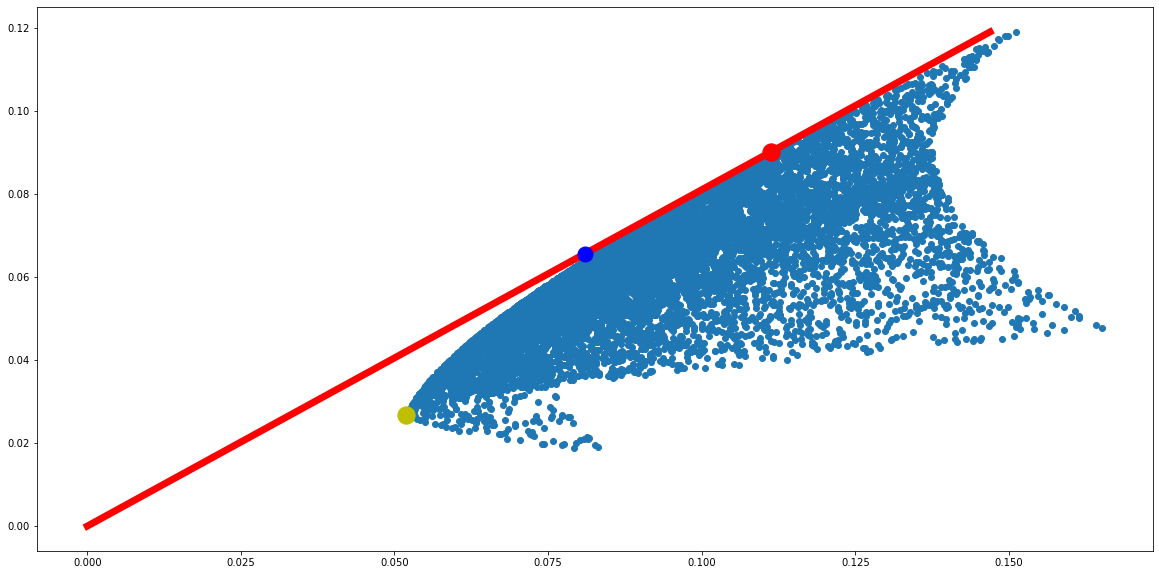

In [101]:
plt.subplots(figsize=(20,10))
#plt.scatter(portfolios['Volatility'], portfolios['Returns'])
plt.scatter(pstd, pret)

#plt.scatter(min_var_port[1], min_var_port[0], color='y')
plt.scatter(stat_port(optv['x'],rmon)[1], stat_port(optv['x'],rmon)[0], color='y', s=300)


#plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g')
plt.scatter(stat_port(opts['x'],rmon)[1], stat_port(opts['x'],rmon)[0], color='r', s=300)

plt.plot(cal_x, cal_y, color='r',linewidth=7.0)

plt.plot(investors_port[2], investors_port[1], 'o', color='b',markersize=15)
